In [488]:
import pandas as pd
import numpy as np

heart_train = pd.read_csv("heart_disease_train.csv")
heart_test = pd.read_csv("heart_disease_test.csv")

In [490]:
missinglist = ["education", "cigsPerDay", "BPMeds", "totChol", "BMI", "heartRate", "glucose"]

In [492]:
heart_train[missinglist] = heart_train[missinglist].apply(lambda x : x.fillna(x.median()), axis=0)
heart_test[missinglist] = heart_test[missinglist].apply(lambda x : x.fillna(x.median()), axis=0)

In [494]:
# Normalize
y_train = heart_train.TenYearCHD.values
x_train = heart_train.iloc[:, :-1]
y_test = heart_test.TenYearCHD.values
x_test = heart_test.iloc[:, :-1]

x_train = (x_train - x_train.mean()) / x_train.std()
x_test = (x_test - x_test.mean()) / x_test.std()
x_train.insert(0, 'intercept', 1)  
x_test.insert(0, 'intercept', 1)  

In [496]:
np.random.seed(240)
# initial_weight = np.random.normal(0, 0.01, x_train.shape[1])
initial_weight = np.random.randn(x_train.shape[1])

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss(initial_weight, X, y):
    l = sigmoid(X.dot(initial_weight))
    return -np.mean(y * np.log(l) + (1 - l) * np.log(1 - l))

def gradient_descent(initial_weight, X, y, lr, num_iter):
    for i in range(num_iter):
        prediction = sigmoid(X.dot(initial_weight))
        gradient = X.T.dot(prediction - y) / len(y)
        initial_weight -= lr * gradient

        if i < 10:
            cost = loss(initial_weight, X, y)
            print(f"Epoch : {i + 1}, loss : {cost}")

    return initial_weight



In [498]:
def predict(X, weights, threshold=0.5):
    probabilities = sigmoid(X.dot(weights))
    return (probabilities >= threshold).astype(int)


In [500]:
# Convert to numpy arrays
X_train = np.array(x_train)
X_test = np.array(x_test)

final_weights = gradient_descent(initial_weight, X_train, y_train, lr=0.1, num_iter=5000)

y_train_pred = predict(X_train, final_weights)
y_test_pred = predict(X_test, final_weights)

Epoch : 1, loss : 0.43666619799458595
Epoch : 2, loss : 0.4379625604005586
Epoch : 3, loss : 0.4392420906042747
Epoch : 4, loss : 0.4405026870451276
Epoch : 5, loss : 0.44174232164896576
Epoch : 6, loss : 0.4429590472081735
Epoch : 7, loss : 0.44415100308625366
Epoch : 8, loss : 0.4453164194734131
Epoch : 9, loss : 0.44645362051326354
Epoch : 10, loss : 0.4475610266559323


In [501]:
# def predict(X, weights, threshold=0.2):
#     probabilities = sigmoid(X.dot(weights))
#     return (probabilities >= threshold).astype(int)

threshold = np.linspace(0, 1, 21)
def predict(X, weights, threshold=threshold):
    probabilities = sigmoid(X.dot(weights))
    accuracies = []
    for thresh in threshold:
        y_pred = (probabilities >= thresh).astype(int)
        correct_predictions = (y_pred == y_test).sum()
        accruacy = correct_predictions / len(y_test)
        accuracies.append((thresh, accruacy))
    return accuracies

threshold_accuracies = predict(X_test, final_weights, threshold)

accuracy_idx = np.argmax(threshold_accuracies, axis=0)
print(f"Best Threshold: {threshold_accuracies[accuracy_idx[1]][0]:.2f}, Best Accuracy: {threshold_accuracies[accuracy_idx[1]][1]:.4f}")

Best Threshold: 0.50, Best Accuracy: 0.8538


We can see that on threshold of 0.5, the accuracy is the best

In [505]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_roc_auc(y_true, y_scores, label="test"):
    thresholds = np.linspace(0, 1, 50)
    TPr_list = []
    FPr_list = []

    # Calculate TPR and FPR for ROC curve
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        TP = np.sum((y_true == 1) & (y_pred == 1))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))
        
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

        TPr_list.append(TPR)
        FPr_list.append(FPR)

    # Calculate metrics
    final_threshold = 0.5
    y_pred_fixed = (y_scores >= final_threshold).astype(int)

    TP = np.sum((y_true == 1) & (y_pred_fixed == 1))
    TN = np.sum((y_true == 0) & (y_pred_fixed == 0))
    FP = np.sum((y_true == 0) & (y_pred_fixed == 1))
    FN = np.sum((y_true == 1) & (y_pred_fixed == 0))

    confusion_matrix = np.array([[TN, FP],
                                  [FN, TP]])

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(FPr_list, TPr_list, label="ROC curve", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    if label == "train":
        plt.title("Train ROC Curve")
    else:
        plt.title("Test ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Calculate AUC
    auc = -1*np.trapz(TPr_list, FPr_list)

    return auc, confusion_matrix, accuracy, precision, recall


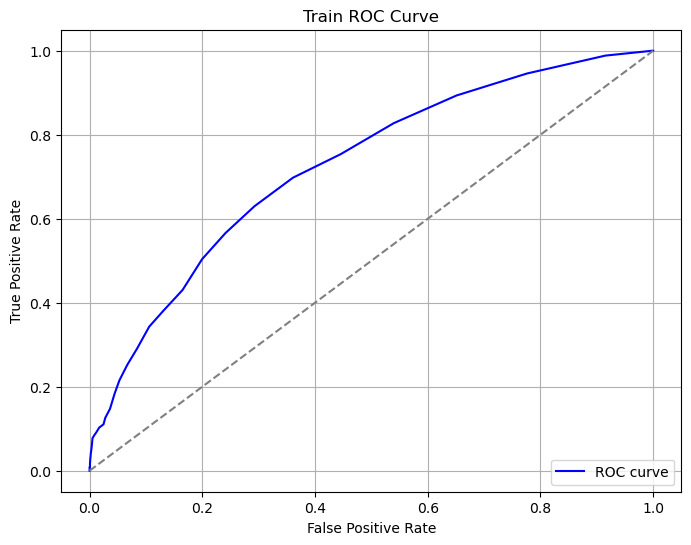

AUC: 0.7244
Confusion Matrix:
[[2860   14]
 [ 478   38]]
Accuracy: 0.8549
Precision: 0.7308
Recall: 0.0736


In [507]:
auc, confusion_matrix, accuracy, precision, recall = calculate_roc_auc(y_train, y_train_scores, label="train")

print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(confusion_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


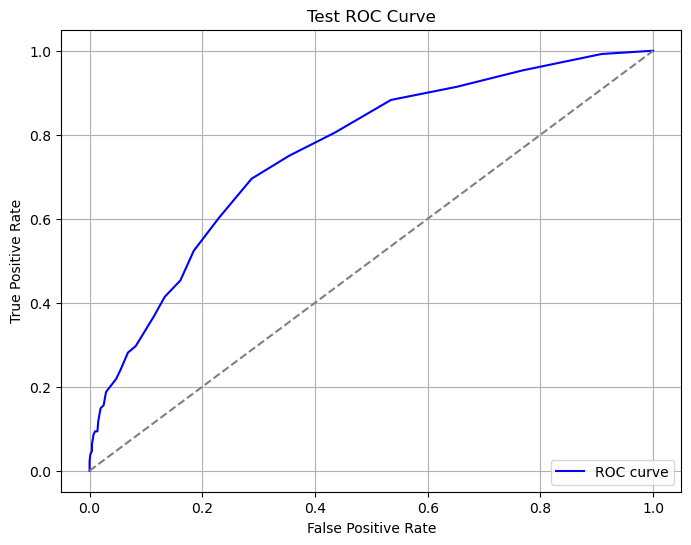

AUC: 0.7574
Confusion Matrix:
[[716   4]
 [120   8]]
Accuracy: 0.8538
Precision: 0.6667
Recall: 0.0625


In [509]:
auc, confusion_matrix, accuracy, precision, recall = calculate_roc_auc(y_test, y_test_scores)

print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(confusion_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
